In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F
from torch.nn.functional import relu
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import numpy as np
import gc
from pylab import *
import os
import random
import json
import pandas as pd
from scipy.stats import norm
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import sys
import matplotlib.pyplot as plt
import time

from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

np.set_printoptions(precision = 4, suppress = True)
torch.set_printoptions(precision=2)
device = torch.device("cuda")
torch.cuda.set_device(0)

In [2]:
# Set Hyperparameters

# Fixed
n_head = 1
d = 5
B = 1000
ma = 1
var = 0.05
shape_k = 0.1

# Number of Iterations to run
max_iters = 10000
hist_stride = 1 # stride for saved model paramters in `train.ipynb'
stride = 250 # stride for computing loss

# We vary the following parameters
n_layer = 3
mode = 'normal'
N = 20
seeds = [0,1,2,3,4,5]

In [3]:
log_dir = 'log'
condnum_plots = {}

np.random.seed(99)
torch.manual_seed(99)
Z, y = generate_data(mode,N,d,B,shape_k)
Z = Z.to(device)
y = y.to(device)
model = Transformer_F(n_layer, n_head, d, var)
model.to(device)

def eval_loss_hess(allparam):
    allparam = allparam.reshape(n_layer, n_head, 2, d, d).to(device)
    output = Z
    for i in range(n_layer):
        Zi = output
        residues = 0
        # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
        for j in range(n_head):
            Pij = allparam[i,j,0,:,:]
            Qij = allparam[i,j,1,:,:]
            residues = residues + attention(Pij,Qij,Zi)
        output = Zi + residues
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean() 
    return loss

for sd in seeds:
    for (alg, toclip, lr) in [('sgd', True, 0.02),('adam', True, 0.02)]:  
        filename = log_dir + '/train_layer{}_N{}_{}_{}_{}_lr{}_sd{}.pth'.format(n_layer, N, mode, alg, toclip, lr, sd)
        loaded_dict = torch.load(filename)
        hist_list = loaded_dict['hist_list']
        condnums = torch.zeros(max_iters//stride)

        for t in range(0,max_iters,stride):
            allparam_loaded = hist_list[t]
            hess = torch.autograd.functional.hessian(eval_loss_hess, allparam_loaded.flatten())
            # compute condition number using diagonal entries of hessian
            diag_hess = torch.abs(torch.diag(hess, 0))
            condnum = torch.max(diag_hess) / torch.median(diag_hess)
            condnums[t//stride] = condnum.item()

        condnum_plots[(alg, toclip, lr, sd)] = condnums

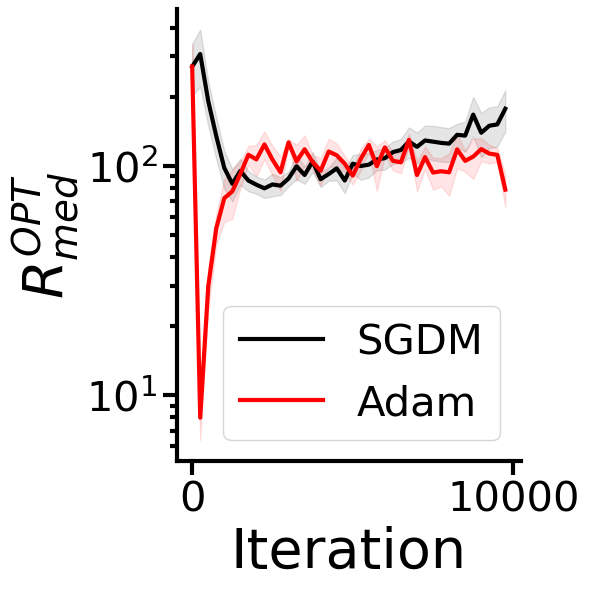

In [4]:
fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (6, 6))

for (alg, toclip, lr) in [('sgd', True, 0.02),('adam', True, 0.02)]:
    condnums = torch.zeros(len(seeds), max_iters//stride)
    for idx, sd in enumerate(seeds):
        condnums[idx] = condnum_plots[(alg, toclip, lr, sd)]
    condnums_mean = torch.mean(condnums, axis=0)
    condnums_std = torch.std(condnums, axis=0)
    if alg == 'sgd':
        ax.plot(range(0,max_iters,stride), condnums_mean, color = 'black', lw = 3,label='SGDM')
        ax.fill_between(range(0,max_iters,stride), condnums_mean-condnums_std/2, condnums_mean+condnums_std/2, color = 'black', alpha = 0.1)
    elif alg == 'adam':
        ax.plot(range(0,max_iters,stride), condnums_mean, color = 'red', lw = 3, label='Adam')
        ax.fill_between(range(0,max_iters,stride), condnums_mean-condnums_std/2, condnums_mean+condnums_std/2, color = 'red', alpha = 0.1)

    ax.set_xlabel('Iteration',fontsize=40)
    ax.set_ylabel(r'$R_{med}^{OPT}$',fontsize=40)

    ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
    ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
    ax.legend(fontsize=30)
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(fig_dir + '/condition_number_layer{}_N{}_{}.pdf'.format(n_layer, N, mode), dpi=600)

In [6]:
print('Condion number SGDM/Adam')
for t in [0, 750, 1250]:
    ratios = torch.zeros(len(seeds))
    for idx, sd in enumerate(seeds):
        ratios[idx] = condnum_plots[('sgd', True, 0.02, sd)][t//stride] / condnum_plots[('adam', True, 0.02, sd)][t//stride]
    ratios_mean = torch.mean(ratios).item()
    ratios_std = torch.std(ratios).item()

    print('Iteration {} | Mean: {}  Std: {}'.format(t, ratios_mean, ratios_std))

Condion number SGDM/Adam
Iteration 0 | Mean: 1.0  Std: 0.0
Iteration 750 | Mean: 2.5689210891723633  Std: 0.9149500727653503
Iteration 1250 | Mean: 1.2976946830749512  Std: 0.7813766598701477
